In [2]:
import pandas as pd
import os
import glob
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.pyplot import figure

In [2]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--cancer_types', nargs="+", type=str,
#                     help='which cancer types to analyze', required=True)

In [8]:
# config = parser.parse_args("--cancer_types Skin-Melanoma".split())
# cancer_types = config.cancer_types

In [3]:
def plot_dendrogram(model, plot_title, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # create the counts of samples under each node
    figure(figsize=(30, 28))
    plt.title(plot_title)

    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)
    plt.xticks(fontsize=10)
    plt.show()

In [4]:
def save_clustered_datafiles(model, data, cancer_type, distance_threshold, linkage, affinity):
    os.makedirs("processed_data/hierarchically_clustered_mutations/", exist_ok=True)
    threshold_dir = f"processed_data/hierarchically_clustered_mutations/{cancer_type}/linkage_{linkage}_affinity_" \
                    f"{affinity}/dist_thresh_{distance_threshold}"
    os.makedirs(threshold_dir,
                exist_ok=True)
    for idx, label in enumerate(np.unique(model.labels_)):
        patient_cluster = data.loc[model.labels_ == label]
        patient_cluster.to_csv(f"{threshold_dir}/C{idx}.csv")
        patient_cluster.sum(axis=0).to_csv(f"{threshold_dir}/aggregated_C{idx}.csv")

    data.sum(axis=0).to_csv(f"{threshold_dir}/aggregated_all.csv")

In [12]:
def cluster_data_and_display_clustering(distance_threshold, mutations_df, plot_title,
                                        save_clusters=False, affinity='euclidean',
                                        affinity_matrix=None, linkage="ward"):
    model = AgglomerativeClustering(n_clusters=None,
                                    distance_threshold=distance_threshold,
                                    linkage=linkage)
    if (affinity == "euclidean"):
        model = model.fit(mutations_df)
    elif (affinity == "pearson"):
        try:
            model = model.fit(affinity_matrix)
        except:
            print("affinity matrix musn't be None when affinity = 1-pearson")
    plot_dendrogram(model,
                    plot_title,
                    truncate_mode="level",
                    p=100,
                    no_labels=True,
                    color_threshold=distance_threshold,
                    above_threshold_color="black")
    if (save_clusters):
        save_clustered_datafiles(model, mutations_df, plot_title, distance_threshold,
                                 linkage, affinity)
    return model

In [6]:
def get_per_cancer_mutations(cancer_type):
    binned_mutation_files = glob.glob(f'processed_data/per_patient_mutations/{cancer_type}/binned_mutations*')
    columns = pd.read_csv(binned_mutation_files[0]).iloc[:, 0].values
    df = pd.DataFrame(columns=columns)

    for file in binned_mutation_files:
        patient_id = file.split("_")[-1].split(".")[0]
        patient_mutations = pd.read_csv(file)['num_mutations']
        df.loc[patient_id] = patient_mutations.values

    agg_mutation_df = pd.read_csv("processed_data/mut_count_data.csv", index_col=0)
    regions_to_consider = agg_mutation_df.loc[~agg_mutation_df.isna().any(axis=1)].index.values
    df = df.loc[:, regions_to_consider]
    return df

In [6]:
Lung_Squamous = get_per_cancer_mutations("Lung-Squamous")

In [7]:
Lung_Squamous = Lung_Squamous.loc[~(Lung_Squamous == 0).all(axis=1)]

/home/mdanb/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


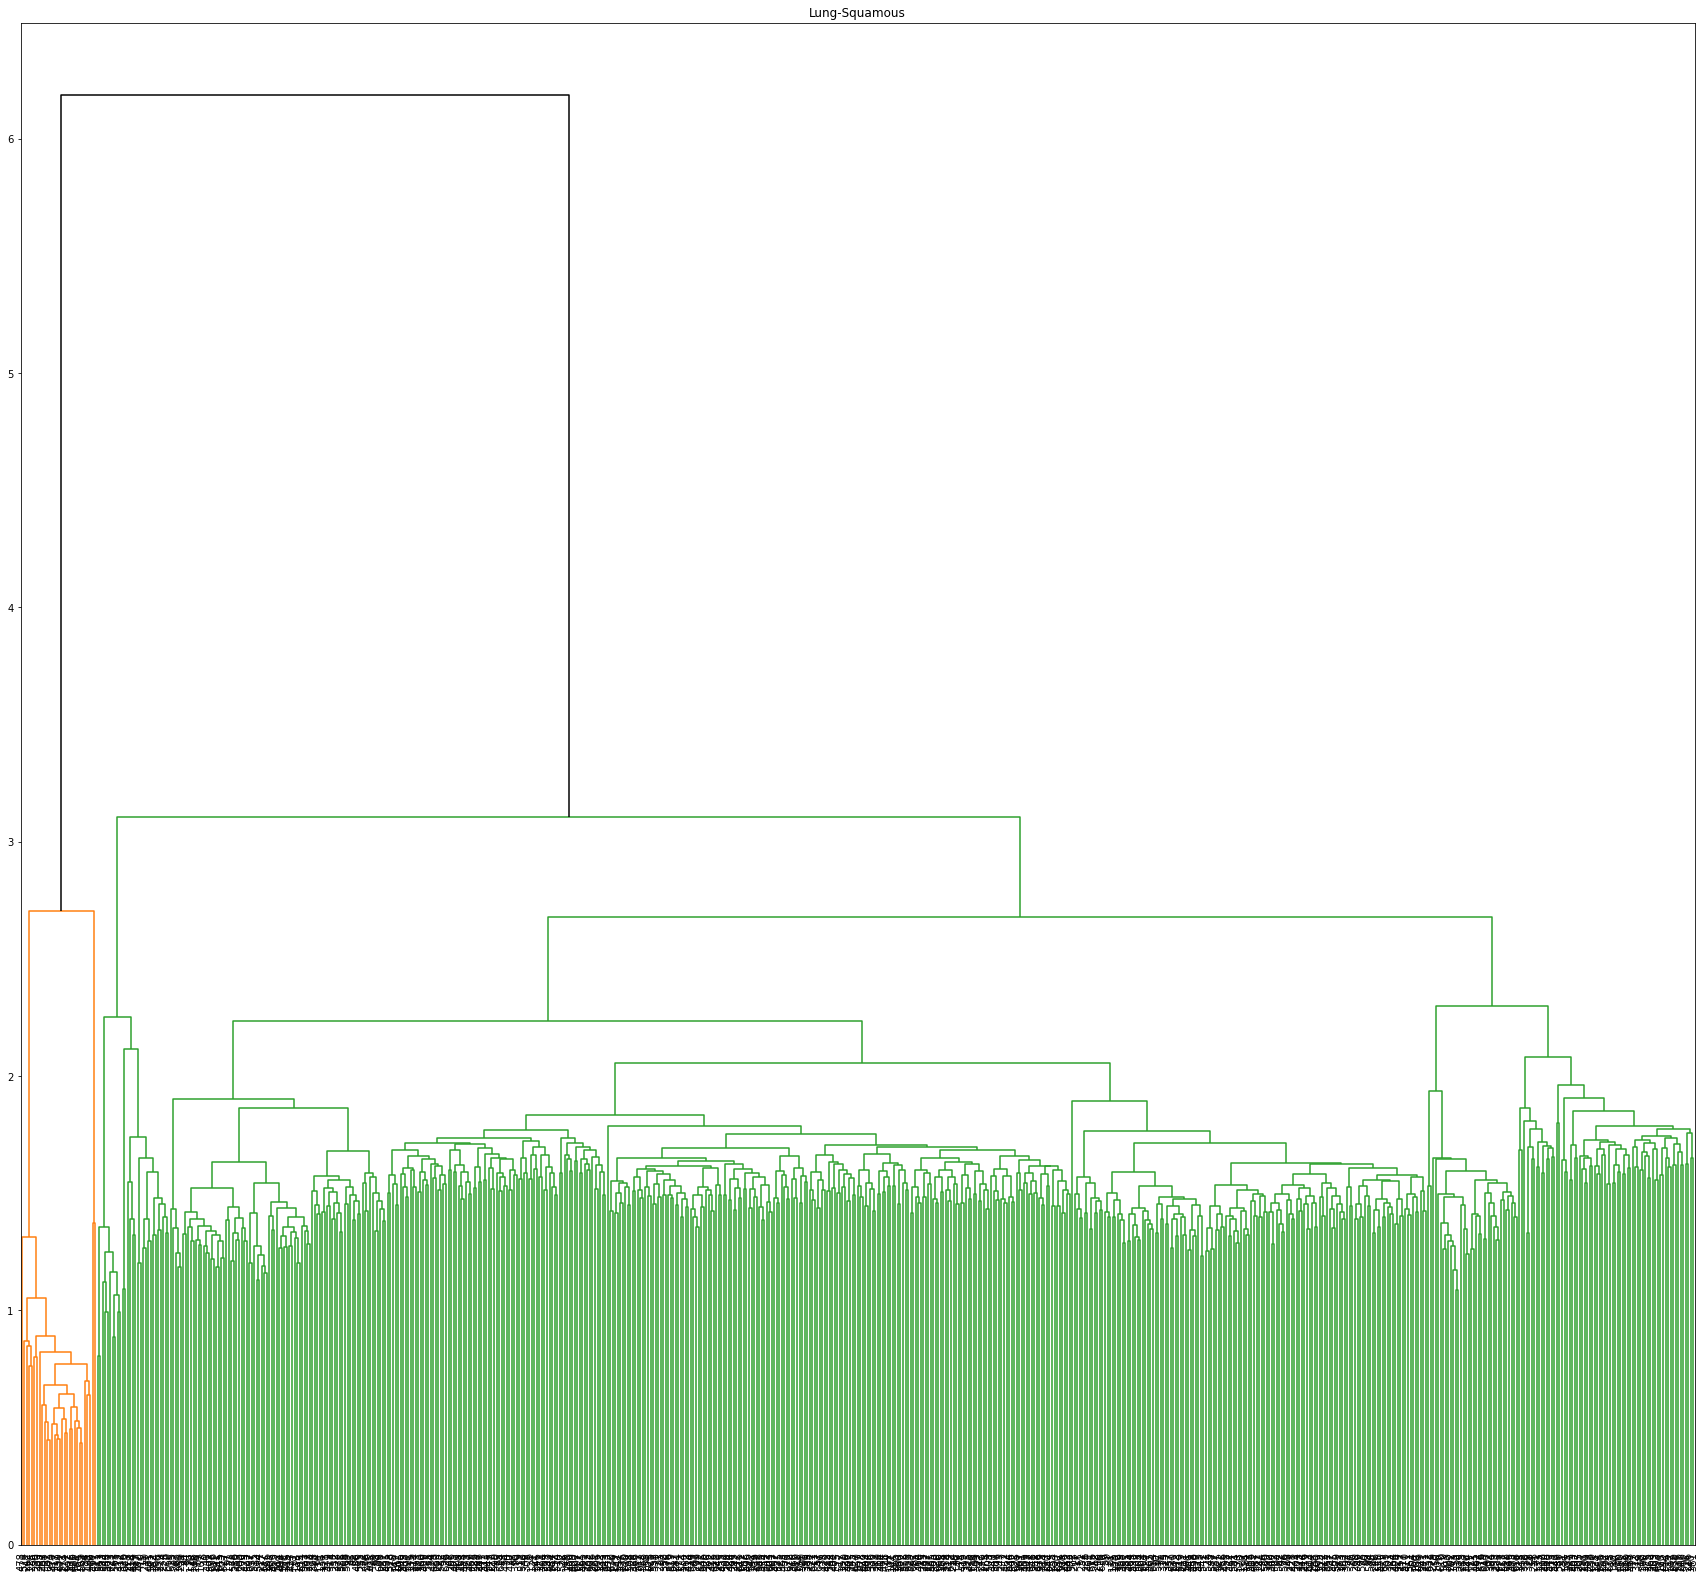

In [8]:
model = cluster_data_and_display_clustering(4, Lung_Squamous, "Lung-Squamous", False,
                                    affinity="pearson", affinity_matrix= 1 - np.corrcoef(Lung_Squamous),
                                    linkage="average")

In [9]:
dense_lung_scc_subset = Lung_Squamous.loc[model.labels_ == 1]

/home/mdanb/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


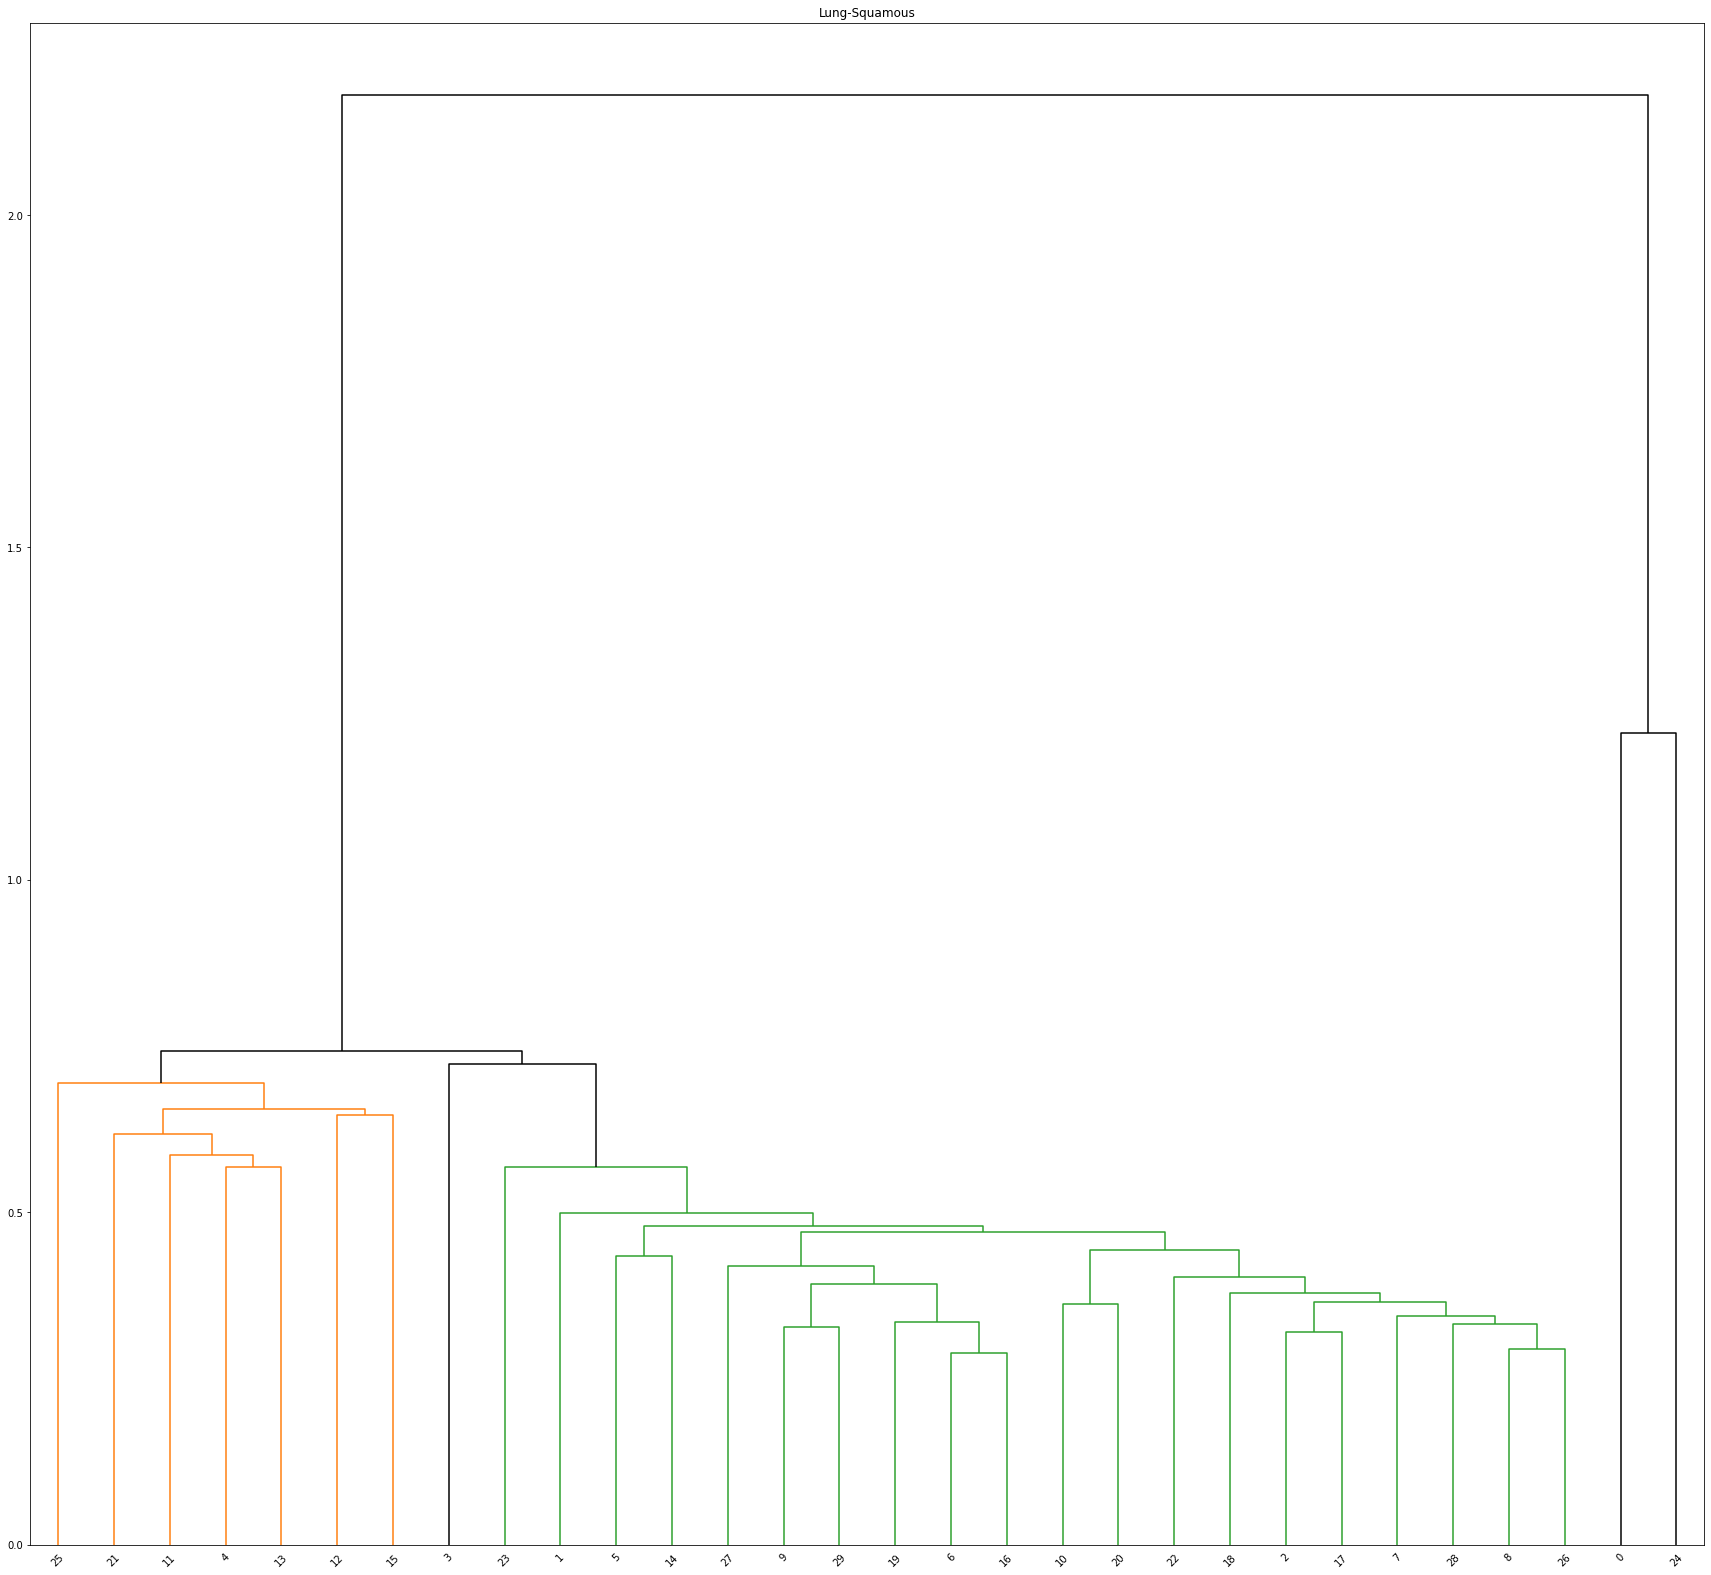

In [10]:
model = cluster_data_and_display_clustering(0.7, dense_lung_scc_subset, "Lung-Squamous", False,
                                    affinity="pearson", affinity_matrix= 1 - np.corrcoef(dense_lung_scc_subset),
                                    linkage="average")

In [11]:
model.labels_

array([2, 1, 1, 4, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       1, 1, 3, 0, 1, 1, 1, 1])

In [12]:
c0 = dense_lung_scc_subset.loc[model.labels_ == 0]

In [13]:
c1 = dense_lung_scc_subset.loc[(model.labels_ == 4) | (model.labels_ == 1)]

In [14]:
c2 = dense_lung_scc_subset.loc[(model.labels_ == 2) | (model.labels_ == 3)]

In [15]:
c0.sum().to_csv("processed_data/hierarchically_clustered_mutations/Lung-Squamous/linkage_average_affinity_pearson/dist_thresh_0.7/aggregated_C0.csv")

In [16]:
c1.sum().to_csv("processed_data/hierarchically_clustered_mutations/Lung-Squamous/linkage_average_affinity_pearson/dist_thresh_0.7/aggregated_C1.csv")

In [17]:
c2.sum().to_csv("processed_data/hierarchically_clustered_mutations/Lung-Squamous/linkage_average_affinity_pearson/dist_thresh_0.7/aggregated_C2.csv")

In [93]:
# cluster_data_and_display_clustering(5, Lung_Squamous, "Lung-Squamous", False,
#                                     affinity="pearson", affinity_matrix= 1 - np.corrcoef(Lung_Squamous),
#                                     linkage="average")

In [23]:
# Skin_Melanoma = get_per_cancer_mutations("Skin-Melanoma")
# cluster_data_and_display_clustering(5, Skin_Melanoma, "Skin-Melanoma", False,
#                                     affinity="pearson", affinity_matrix= 1 - np.corrcoef(Skin_Melanoma),
#                                     linkage="average")

In [21]:
# Skin_Melanoma = get_per_cancer_mutations("Skin-Melanoma")
# cluster_data_and_display_clustering(2, Skin_Melanoma, "Skin-Melanoma", True,
#                                     affinity="pearson", affinity_matrix= 1 - np.corrcoef(Skin_Melanoma),
#                                     linkage="average")

In [22]:
# Skin_Melanoma = get_per_cancer_mutations("Skin-Melanoma")
# cluster_data_and_display_clustering(1.8, Skin_Melanoma, "Skin-Melanoma", True,
#                                     affinity="pearson", affinity_matrix= 1 - np.corrcoef(Skin_Melanoma),
#                                     linkage="average")

In [23]:
# Skin_Melanoma = get_per_cancer_mutations("Skin-Melanoma")
# cluster_data_and_display_clustering(1.7, Skin_Melanoma, "Skin-Melanoma", True,
#                                     affinity="pearson", affinity_matrix= 1 - np.corrcoef(Skin_Melanoma),
#                                     linkage="average")

In [9]:
Colorectal = get_per_cancer_mutations("Colorectal")
Colorectal = Colorectal.loc[~(Colorectal == 0).all(axis=1)]

/home/mdanb/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


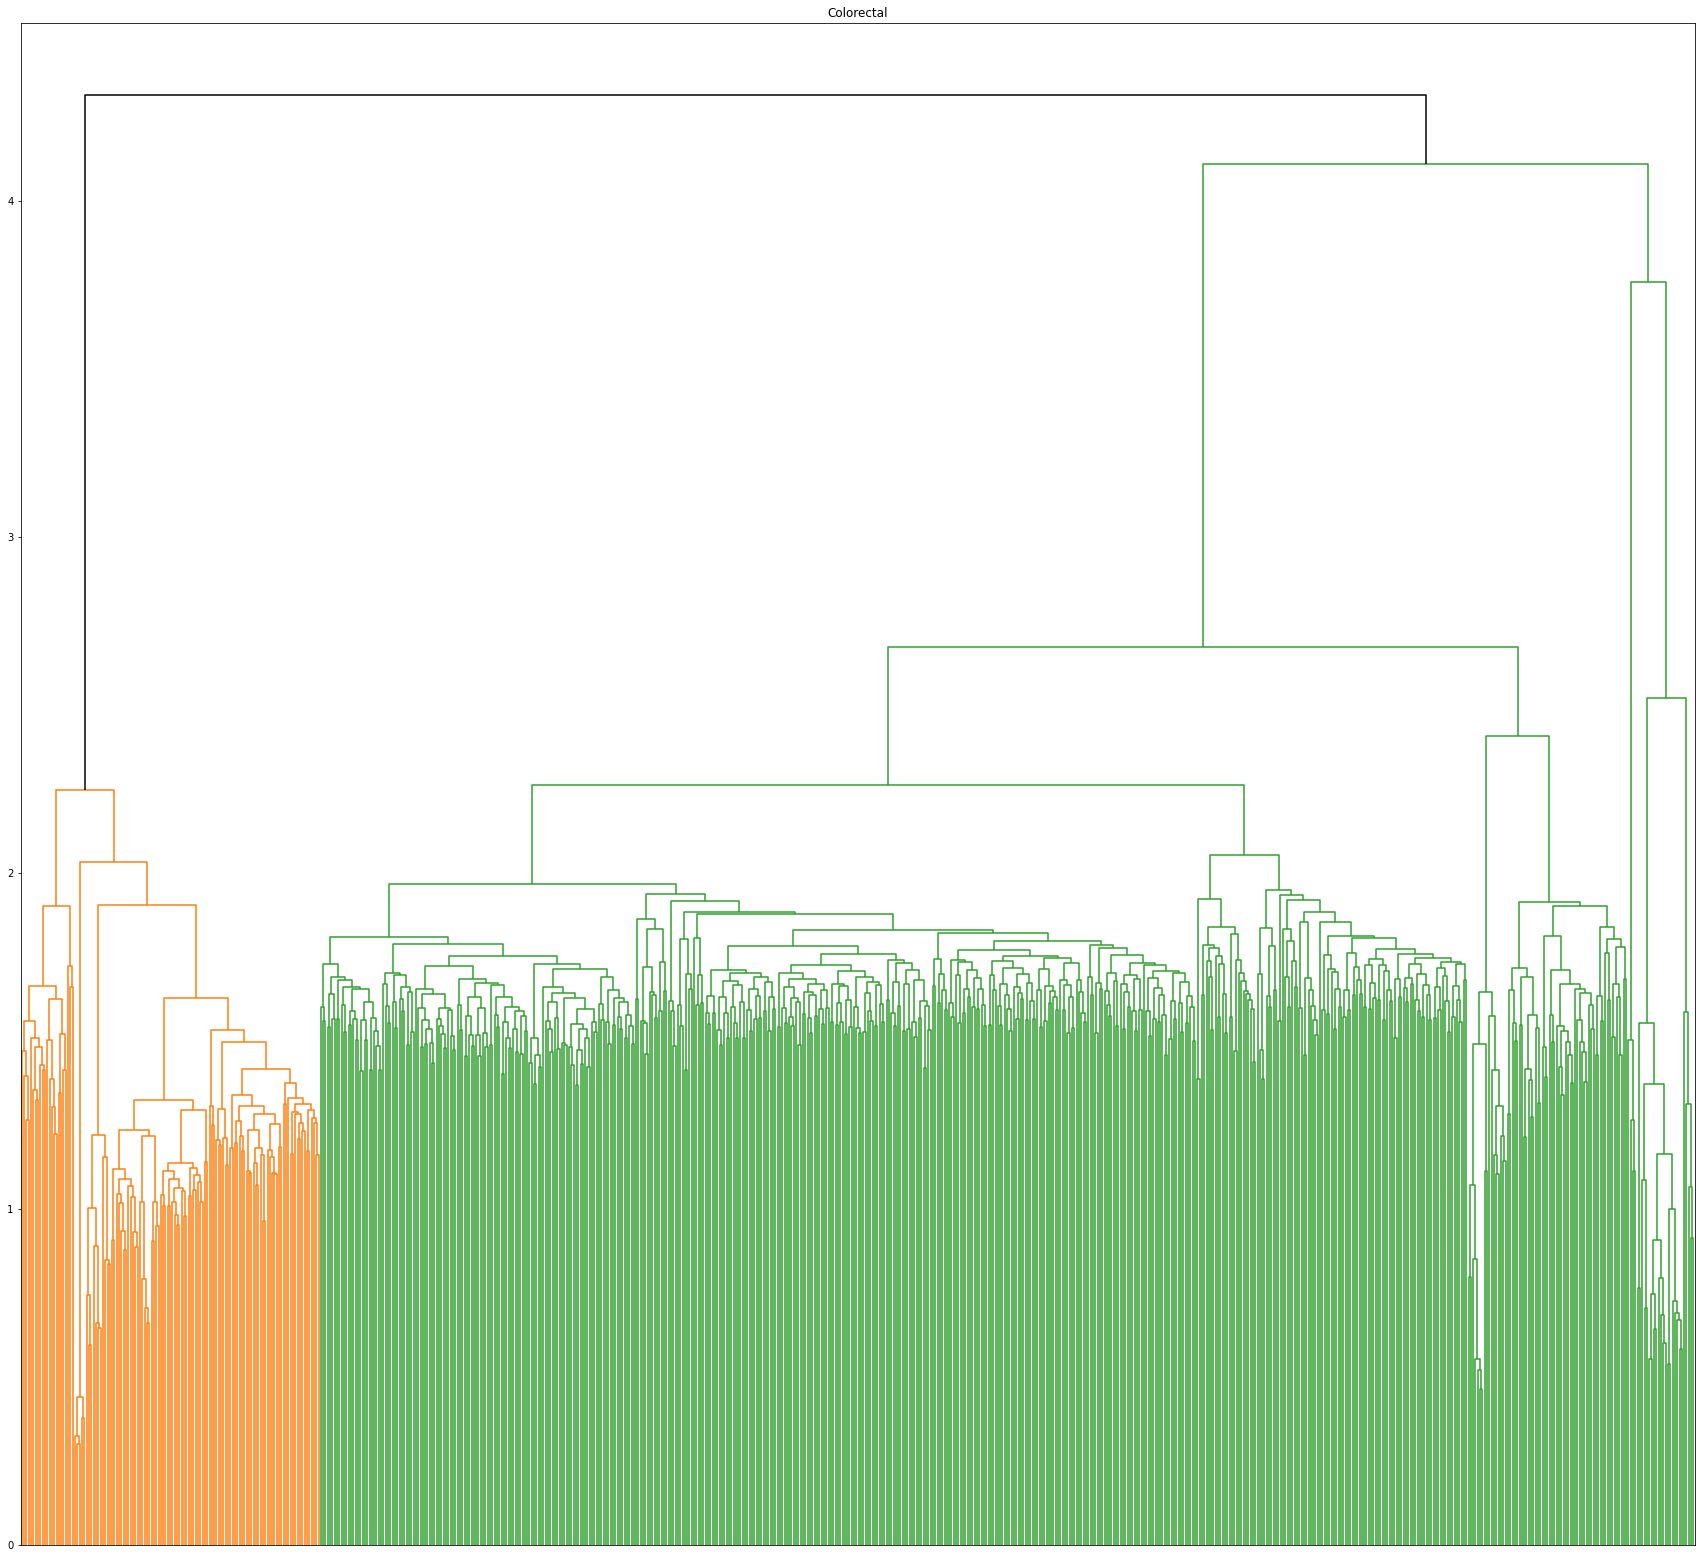

In [26]:
model = cluster_data_and_display_clustering(4.12, Colorectal, "Colorectal", True,
                                    affinity="pearson", affinity_matrix= 1 - np.corrcoef(Colorectal),
                                    linkage="average")

/home/mdanb/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


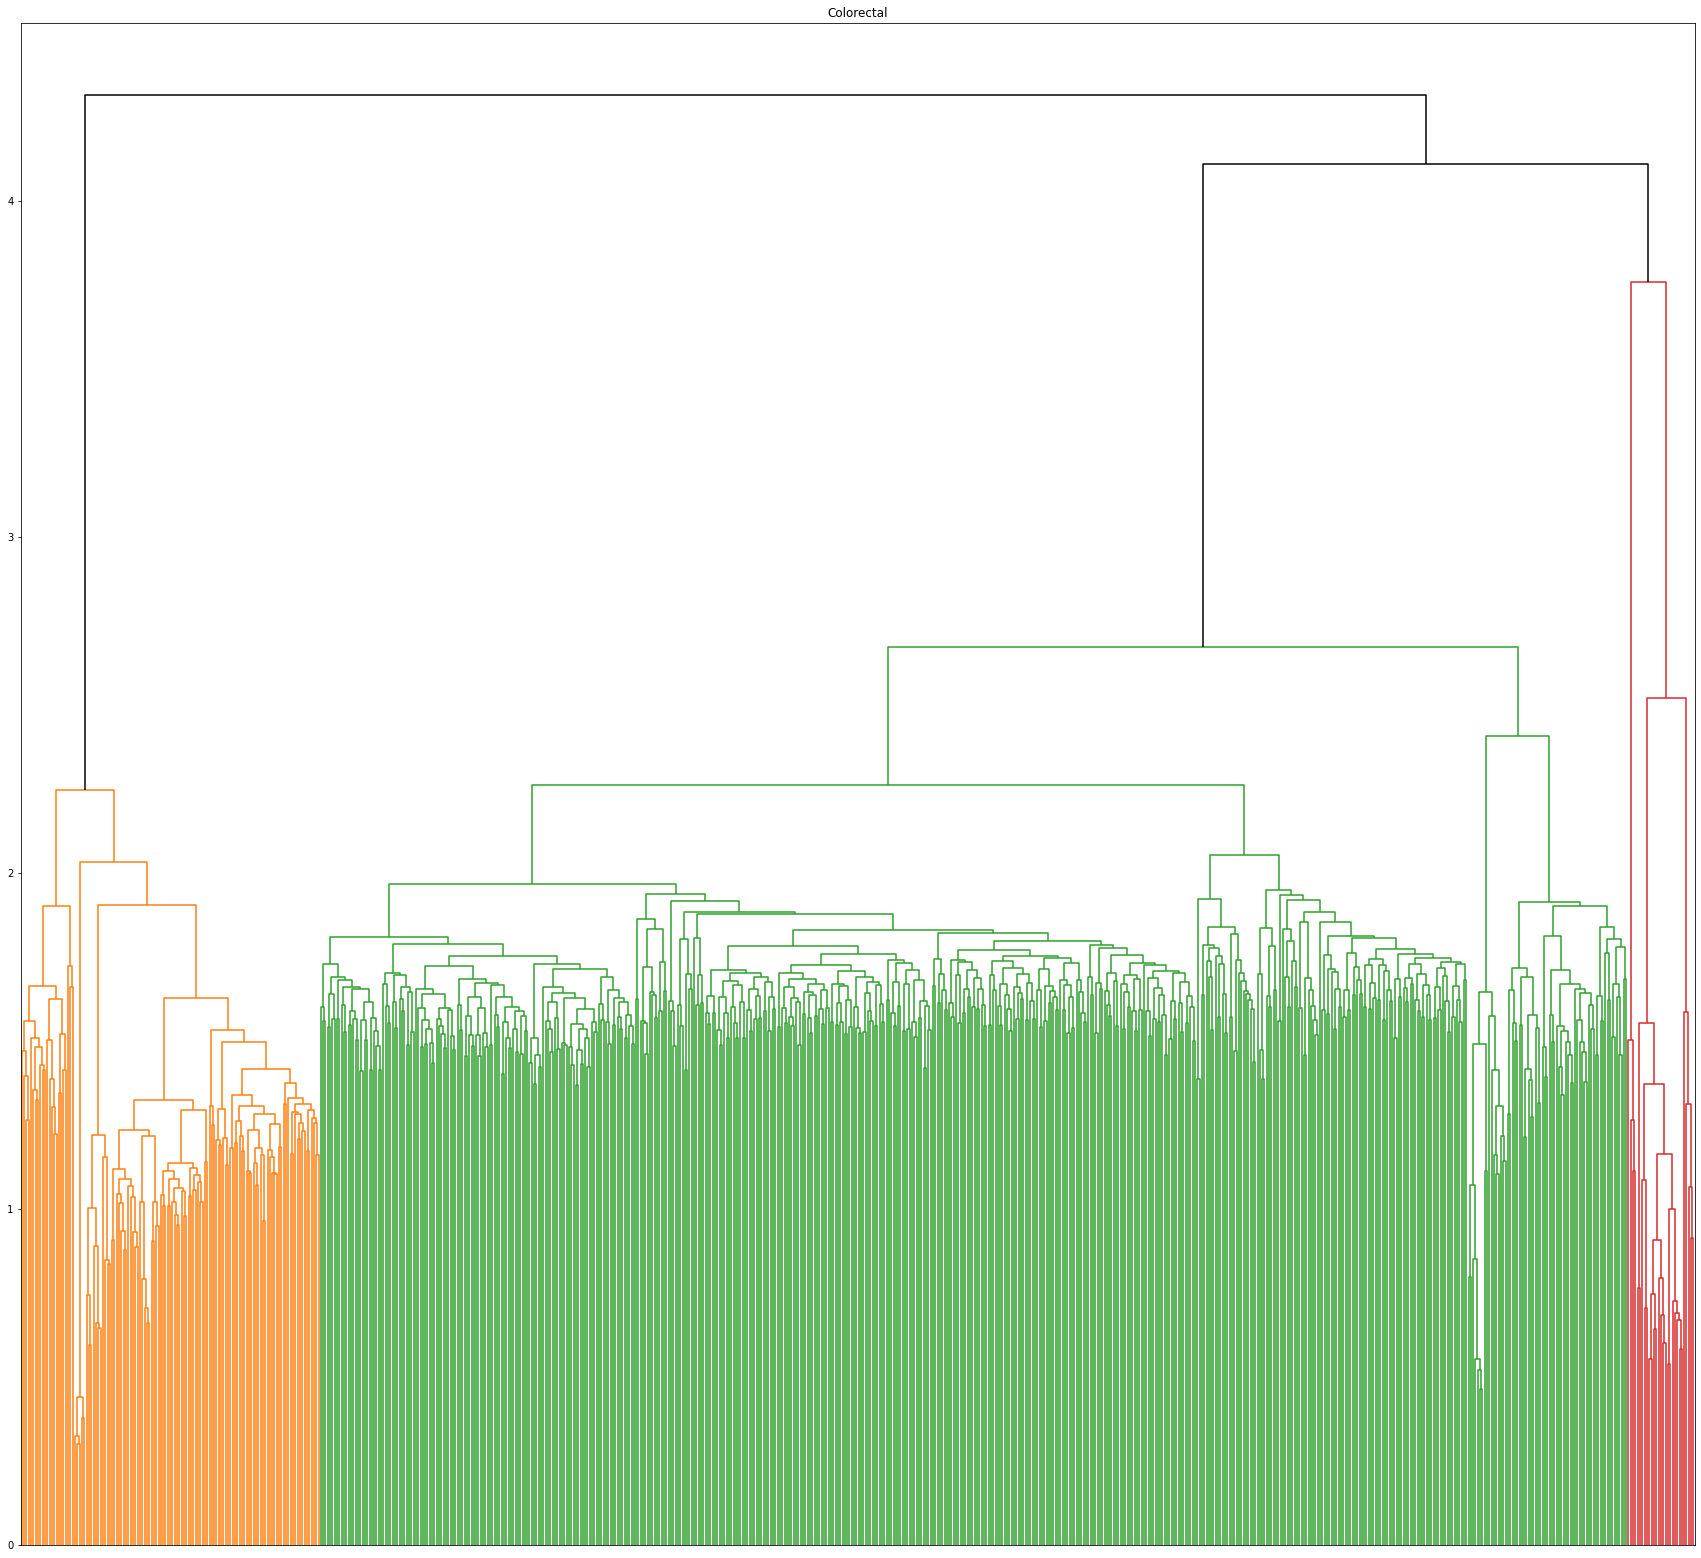

In [21]:
model = cluster_data_and_display_clustering(4, Colorectal, "Colorectal", True,
                                    affinity="pearson", affinity_matrix= 1 - np.corrcoef(Colorectal),
                                    linkage="average")

/home/mdanb/.local/lib/python3.8/site-packages/sklearn/cluster/_agglomerative.py:542: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


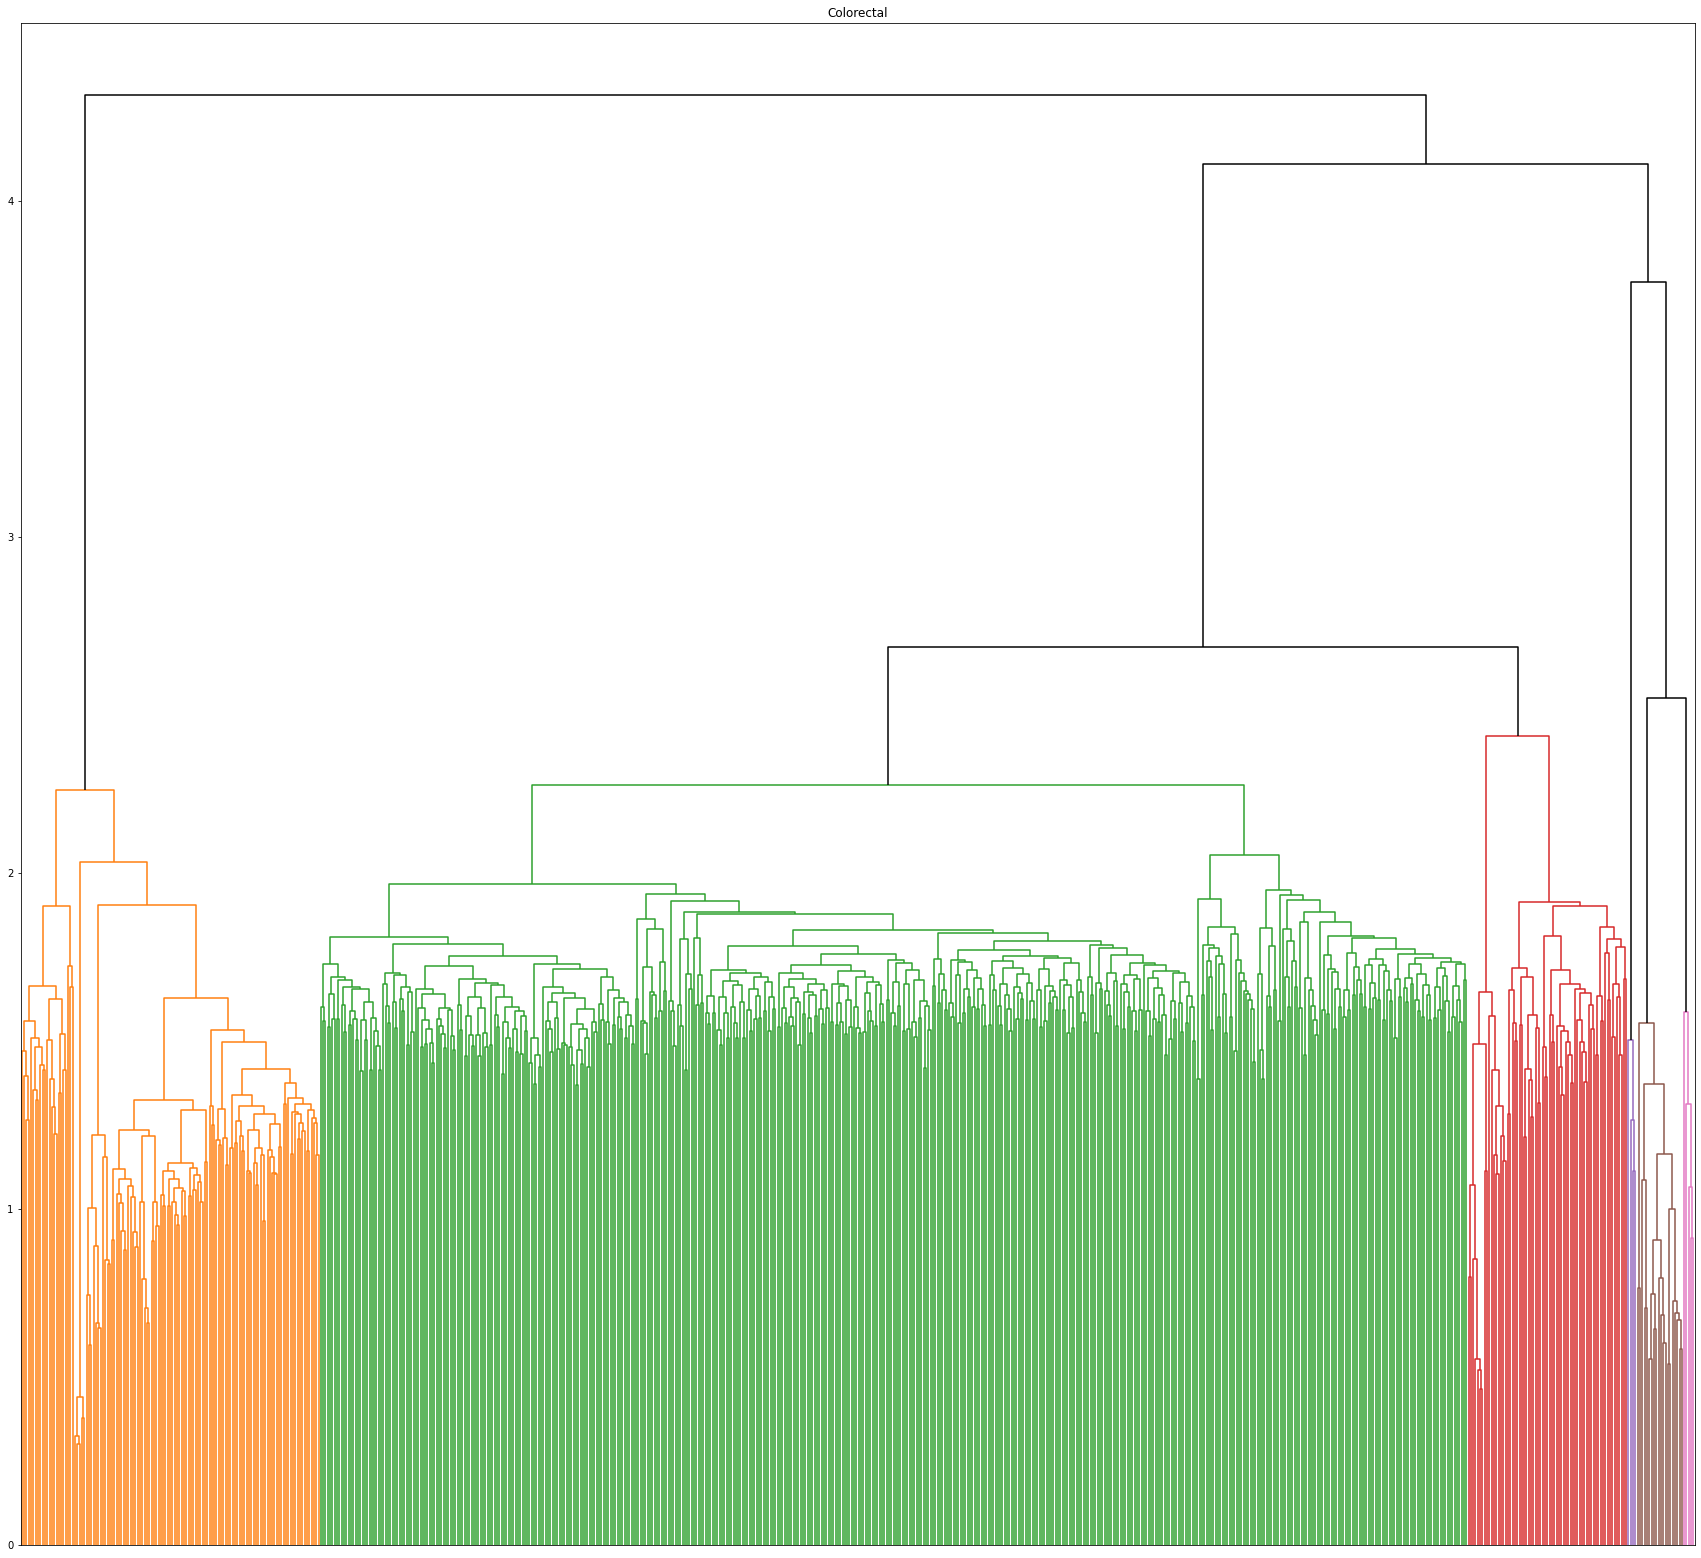

In [25]:
model = cluster_data_and_display_clustering(2.5, Colorectal, "Colorectal", False,
                                    affinity="pearson", affinity_matrix= 1 - np.corrcoef(Colorectal),
                                    linkage="average")